/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


100%|███████████████████████████████████████████████████████████████████████████████████| 390/390 [00:00<00:00, 987.59it/s]


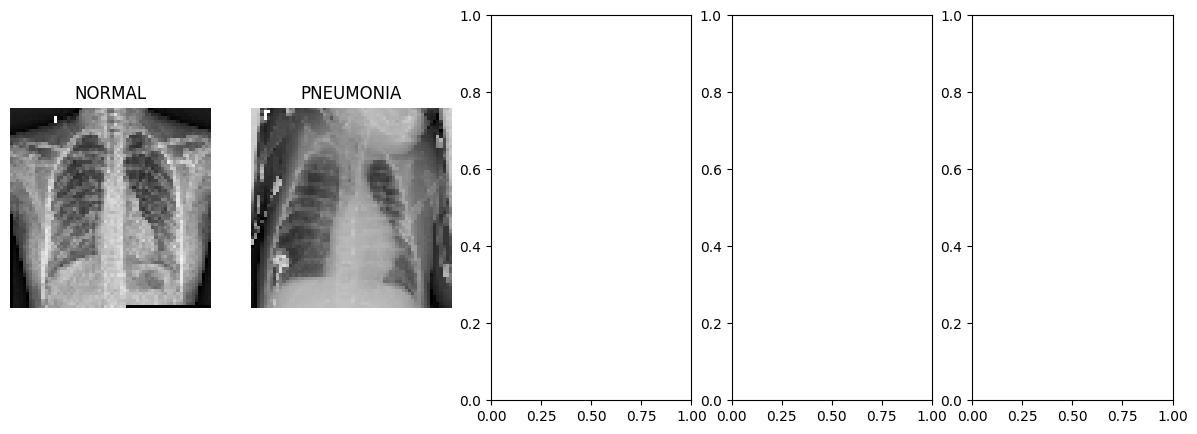

In [23]:
def load_images_and_labels(dataset_path, augment=False):
    X, Y = [], []
    for category in ["NORMAL", "PNEUMONIA"]:
        path = os.path.join(dataset_path, category)
        label = 0 if category == "NORMAL" else 1
        for img_name in tqdm(os.listdir(path)[:1000]):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, IMG_SIZE)
                img = np.expand_dims(img, axis=-1)
                X.append(img)
                Y.append(label)
    X = np.array(X) / 255.0
    Y = np.array(Y)
    return X, Y

X_train, Y_train = load_images_and_labels(os.path.join(DATASET_PATH, "train"))
X_test, Y_test = load_images_and_labels(os.path.join(DATASET_PATH, "test"))

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
categories = ["NORMAL", "PNEUMONIA"]

for i, category in enumerate(categories):
    path = os.path.join(DATASET_PATH, "train", category)
    img_name = os.listdir(path)[0]
    img = cv2.imread(os.path.join(path, img_name), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMG_SIZE)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(category)
    axes[i].axis("off")

plt.show()



📊 Vérification des tailles des données après chargement :
X_train shape: (5216, 64, 64)
Y_train shape: (5216,)
X_test shape: (624, 64, 64)
Y_test shape: (624,)
X_train_knn shape après reshape: (5216, 4096)
Fitting 5 folds for each of 80 candidates, totalling 400 fits

🔍 Meilleurs paramètres trouvés : {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'uniform', 'pca__n_components': 50}

✅ Accuracy du modèle KNN : 0.7724

📊 Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      0.42      0.58       234
           1       0.74      0.98      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.70      0.71       624
weighted avg       0.81      0.77      0.74       624



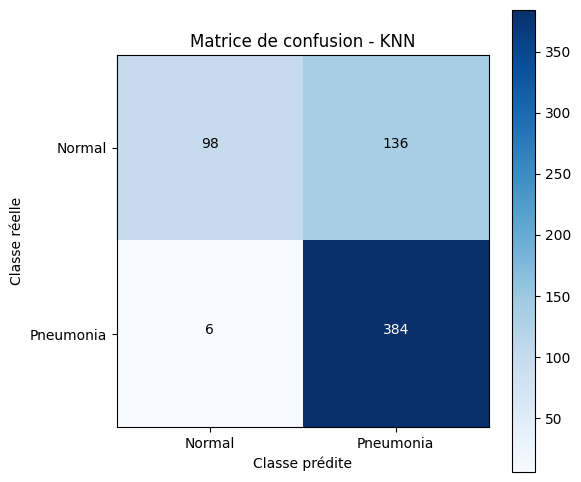

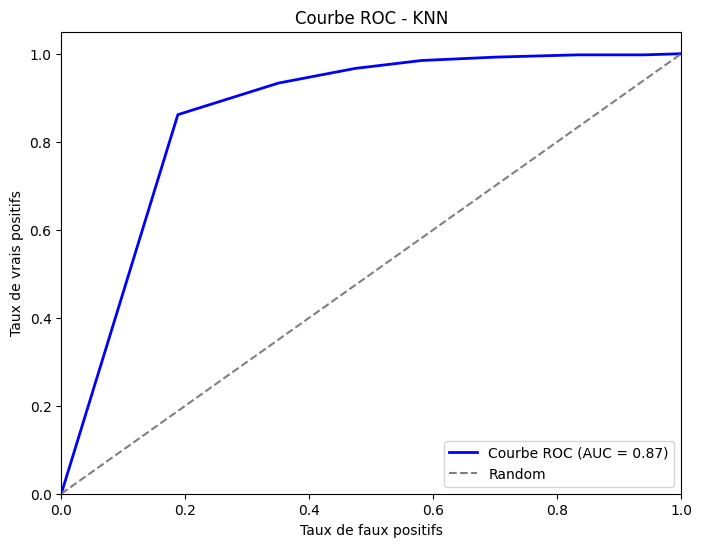

In [2]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

X_train = np.load("/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/data/X_train.npy")
Y_train = np.load("/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/data/Y_train.npy")
X_test = np.load("/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/data/X_test.npy")
Y_test = np.load("/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/data/Y_test.npy")

print("\n📊 Vérification des tailles des données après chargement :")
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

Y_train = Y_train.ravel()
Y_test = Y_test.ravel()

if X_train.shape[0] != Y_train.shape[0] or X_test.shape[0] != Y_test.shape[0]:
    raise ValueError("❌ Erreur : Incohérence entre le nombre d'images et de labels.")

X_train_knn = X_train.reshape(X_train.shape[0], -1)
X_test_knn = X_test.reshape(X_test.shape[0], -1)
print(f"X_train_knn shape après reshape: {X_train_knn.shape}")

scaler = StandardScaler()
X_train_knn = scaler.fit_transform(X_train_knn)
X_test_knn = scaler.transform(X_test_knn)

pipeline = Pipeline([
    ('pca', PCA()),
    ('knn', KNeighborsClassifier(n_jobs=-1))
])

param_grid = {
    'pca__n_components': [50, 100, 150, 200, 250],
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__metric': ['euclidean', 'manhattan'],
    'knn__weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='balanced_accuracy', verbose=1)
grid_search.fit(X_train_knn, Y_train)
print("\n🔍 Meilleurs paramètres trouvés :", grid_search.best_params_)

best_pipeline = grid_search.best_estimator_
Y_pred_knn = best_pipeline.predict(X_test_knn)
accuracy = accuracy_score(Y_test, Y_pred_knn)

print(f"\n✅ Accuracy du modèle KNN : {accuracy:.4f}")
print("\n📊 Rapport de classification :\n", classification_report(Y_test, Y_pred_knn))

cm = confusion_matrix(Y_test, Y_pred_knn)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de confusion - KNN")
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['Normal', 'Pneumonia'])
plt.yticks(tick_marks, ['Normal', 'Pneumonia'])

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()


Y_pred_proba = best_pipeline.predict_proba(X_test_knn)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"Courbe ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC - KNN")
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()


/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


🔍 X_train: (5216, 64, 64), Y_train: (5216,)
🔍 X_test: (624, 64, 64), Y_test: (624,)
⚖️ Poids des classes : {np.int64(0): np.float64(1.9448173005219984), np.int64(1): np.float64(0.6730322580645162)}
Epoch 1/10


/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.7555 - loss: 0.8708
Epoch 1: val_loss improved from inf to 1.61930, saving model to models/best_cnn_model_128.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 148s 890ms/step - accuracy: 0.7559 - loss: 0.8701 - val_accuracy: 0.6250 - val_loss: 1.6193 - learning_rate: 2.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.8646 - loss: 0.6604
Epoch 2: val_loss did not improve from 1.61930
163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 826ms/step - accuracy: 0.8646 - loss: 0.6603 - val_accuracy: 0.6250 - val_loss: 3.8685 - learning_rate: 2.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.8894 - loss: 0.5808
Epoch 3: val_loss did not improve from 1.61930
163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 811ms/step - accuracy: 0.8893 - loss: 0.5808 - val_accuracy: 0.6250 - val_loss: 5.7852 - learning_rate: 2.0000e-05
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.8701 - loss: 0.6174
Epoch 4: ReduceLROnPla

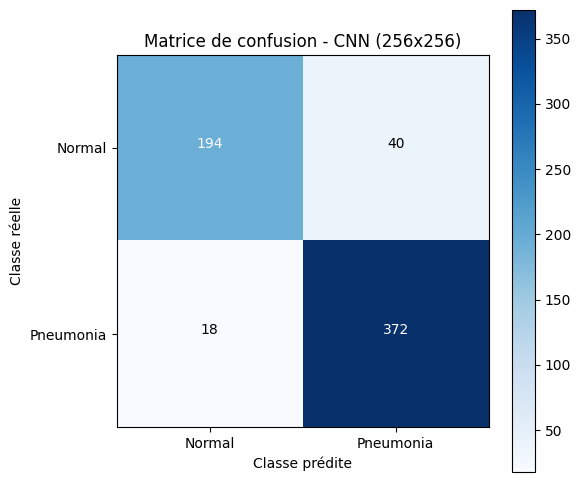

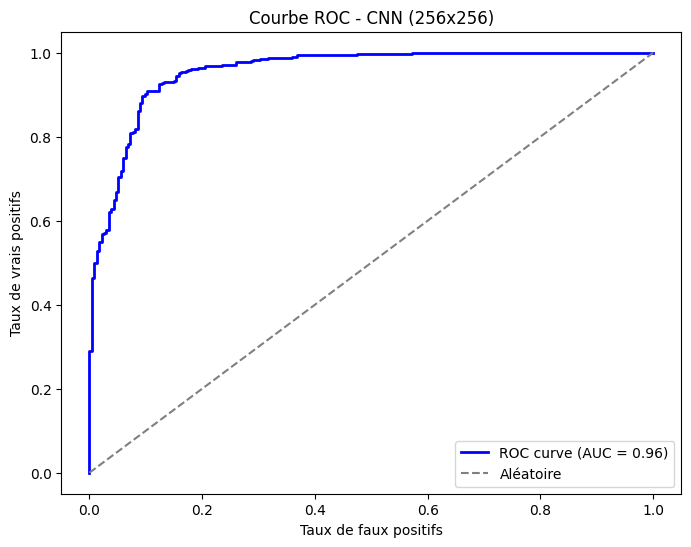

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

X_train = np.load("/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/data/X_train.npy")
Y_train = np.load("/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/data/Y_train.npy")
X_test = np.load("/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/data/X_test.npy")
Y_test = np.load("/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/data/Y_test.npy")

print(f"🔍 X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"🔍 X_test: {X_test.shape}, Y_test: {Y_test.shape}")

IMG_SIZE = (256, 256)
X_train_resized = np.array([tf.image.resize(np.expand_dims(img, -1), IMG_SIZE).numpy() for img in X_train])
X_test_resized = np.array([tf.image.resize(np.expand_dims(img, -1), IMG_SIZE).numpy() for img in X_test])

X_train_resized = X_train_resized.astype('float32') / 255.0
X_test_resized = X_test_resized.astype('float32') / 255.0

classes = np.unique(Y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_train)
class_weights_dict = dict(zip(classes, class_weights))
print(f"⚖️ Poids des classes : {class_weights_dict}")

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train_resized)

model = models.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002),
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint("models/best_cnn_model_128.keras", monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(datagen.flow(X_train_resized, Y_train, batch_size=32),
                    epochs=10,
                    validation_data=(X_test_resized, Y_test),
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

Y_pred_prob = model.predict(X_test_resized)
Y_pred = (Y_pred_prob > 0.5).astype("int32")
accuracy = np.mean(Y_pred.flatten() == Y_test)

print(f"\n✅ Accuracy du modèle CNN : {accuracy:.4f}")
print("\n📊 Rapport de classification :\n", classification_report(Y_test, Y_pred))

cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de confusion - CNN (256x256)")
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['Normal', 'Pneumonia'])
plt.yticks(tick_marks, ['Normal', 'Pneumonia'])

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Aléatoire")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC - CNN (256x256)")
plt.legend(loc="lower right")
plt.show()

model.save("models/cnn_256_V2.keras")


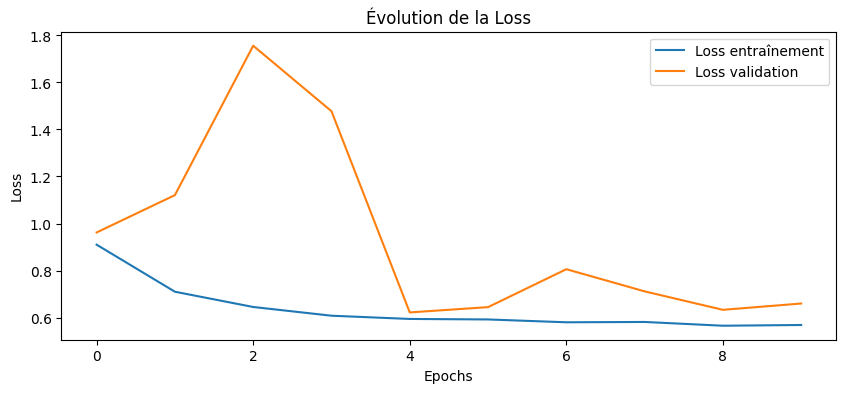

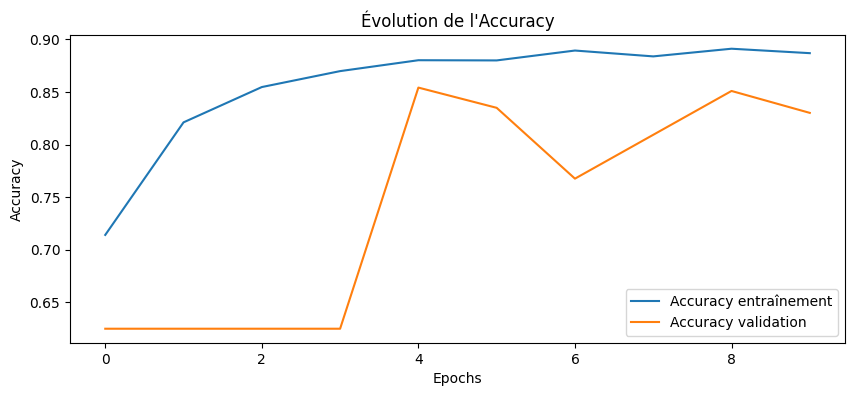

In [2]:
import matplotlib.pyplot as plt

history_dict = history.history

plt.figure(figsize=(10, 4))
plt.plot(history_dict['loss'], label='Loss entraînement')
plt.plot(history_dict['val_loss'], label='Loss validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Évolution de la Loss")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history_dict['accuracy'], label='Accuracy entraînement')
plt.plot(history_dict['val_accuracy'], label='Accuracy validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Évolution de l'Accuracy")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
🔍 Prédiction : NORMAL (Probabilité: 0.0000)


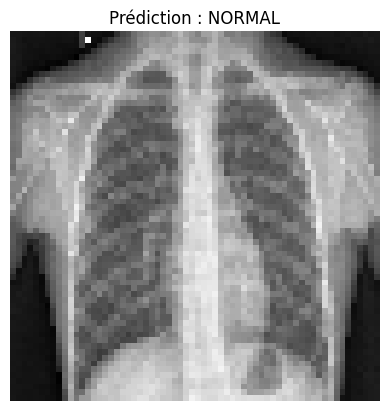

In [3]:
import cv2
import os

def predict_image(image_path):
    IMG_SIZE = (64, 64)
    
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("❌ Erreur : Impossible de charger l'image.")
        return
    
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0
    img = img.reshape(1, 64, 64, 1)

    prediction = model.predict(img)[0][0]
    label = "PNEUMONIA" if prediction > 0.5 else "NORMAL"

    print(f"🔍 Prédiction : {label} (Probabilité: {prediction:.4f})")

    plt.imshow(img.reshape(64, 64), cmap='gray')
    plt.title(f"Prédiction : {label}")
    plt.axis("off")
    plt.show()

test_image_path = "../data/chest_xray/test/NORMAL/IM-0001-0001.jpeg"
if os.path.exists(test_image_path):
    predict_image(test_image_path)
else:
    print("❌ L'image test spécifiée n'existe pas. Vérifie le chemin.")
